In [6]:
# Import necessary libraries
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from io import BytesIO
import imageio.v2 as imageio

# Set the theme for seaborn plots
sns.set_theme()

In [7]:
# Define the oscillator function
def oscillator(t, x0, u0, gamma, omega0):
    # Underdamped case
    if omega0 > gamma:
        omega = np.sqrt(omega0**2 - gamma**2)
        delta = np.arctan((u0 + gamma * x0) / (omega * x0))
        A = x0 / np.cos(delta)
        x = A * np.exp(-gamma * t) * np.cos(omega * t - delta)
    # Overdamped case
    elif omega0 < gamma:
        omega = np.sqrt(gamma**2 - omega0**2)
        A = ((omega + gamma) * x0 + u0) / (2 * omega)
        B = ((omega - gamma) * x0 - u0) / (2 * omega)
        x = A * np.exp((-gamma + omega) * t) + B * np.exp((-gamma - omega) * t)
    # Critically damped case
    else:
        A = x0
        B = u0 + gamma * x0
        x = (A + B * t) * np.exp(-gamma * t)
        
    return x

# Define the ODE system function
@tf.function
def ode_system(t, model, gamma, omega0, ic_x_t0, ic_dx_t0):
    # Convert initial conditions to tensors
    ic_x_t0 = tf.constant(ic_x_t0, dtype=tf.float32)
    ic_dx_t0 = tf.constant(ic_dx_t0, dtype=tf.float32)

    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as g:
        g.watch(t)

        with tf.GradientTape() as gg:
            gg.watch(t)

            # Predict the position using the model
            x = model(t)

            # Compute the first derivative of x with respect to t
            dx_dt = gg.gradient(x, t)
        # Compute the second derivative of x with respect to t
        d2x_dt2 = g.gradient(dx_dt, t)

    # Compute the ODE loss
    ode_loss = d2x_dt2 + 2 * gamma * dx_dt + omega0**2 * x

    # Compute the initial condition losses
    IC_loss_x = x[0] - ic_x_t0
    IC_loss_dx = dx_dt[0] - ic_dx_t0

    # Compute the total loss
    total_loss = 0.0001 * tf.reduce_mean(tf.square(ode_loss)) + tf.reduce_mean(tf.square(IC_loss_x)) + tf.reduce_mean(tf.square(IC_loss_dx))
    return total_loss

In [8]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1)], name='NN')

# Print the model summary
model.summary()

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,209 (8.63 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

-- Start --

.........
Iteration  3000, Loss: 0.0528
.........
Iteration  6000, Loss: 0.0286
.........
Iteration  9000, Loss: 0.0115
.........
Iteration 12000, Loss: 0.0113
.........
Iteration 15000, Loss: 0.0089
.........
Iteration 18000, Loss: 0.0082
.........
Iteration 21000, Loss: 0.0072
.........
Iteration 24000, Loss: 0.0051
.........
Iteration 27000, Loss: 0.0030
.........
Iteration 30000, Loss: 0.0017

Saving the animation...

-- End --


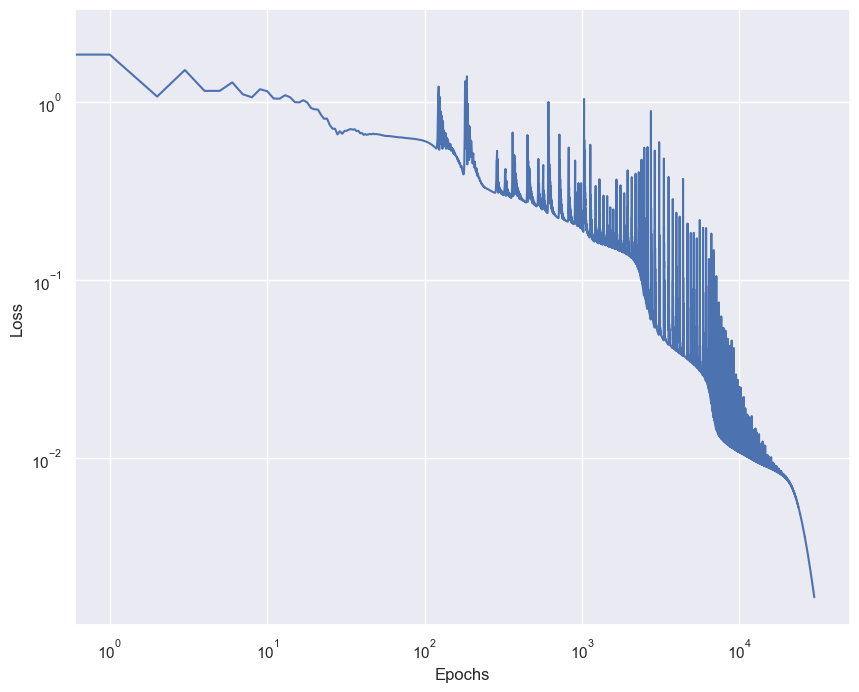

In [9]:
# Define parameters for training and animation
gamma = 2
omega0 = 20
ic_x_t0 = 1
ic_dx_t0 = -1
gif_duration = 5 # seconds

# Generate training time points
t_train = np.linspace(0, 1, 64)

# Define training parameters
epochs = int(3e+4)
initial_learning_rate = 1e-2
final_learning_rate = 1e-5
decay_steps = int(1e+2)

# Initialize lists to store training loss and frames for the GIF
train_loss_record = []
frames = []  # List to store frames for the GIF

# Convert training time points to tensor
t_train_tensor = tf.convert_to_tensor(t_train[:, None], dtype=tf.float32)
# Compute the true solution using the oscillator function
x_true = oscillator(t_train, ic_x_t0, ic_dx_t0, gamma, omega0)

# Define learning rate schedule
decay_rate = (final_learning_rate / initial_learning_rate)**(decay_steps / epochs)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate)
# Define the optimizer
optm = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define parameters for animation
fps = 25 # frames per second
#NOTE: 1000 / fps (must be a multiple of 10, I whould suggest >= 40)
frame_duration = int(1000 / fps)
epochs_per_frame = epochs / (gif_duration * fps)
adj_epochs = epochs_per_frame

# Define the number of prints and dots for the training progress
prints = epochs // 10
dots = prints // 10
digits = len(str(epochs))

print("-- Start --\n")
for itr in range(1, epochs+1):
    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Compute the training loss
        train_loss = ode_system(t_train_tensor, model, gamma, omega0, ic_x_t0, ic_dx_t0)
        train_loss_record.append(train_loss)

        # Compute the gradients of the loss with respect to the model parameters
        grad_w = tape.gradient(train_loss, model.trainable_variables)
        # Apply the gradients to update the model parameters
        optm.apply_gradients(zip(grad_w, model.trainable_variables))

    # Create the animation
    if itr / adj_epochs >= 1:
        adj_epochs += epochs_per_frame
        # Predict the position using the model
        predicts = model(t_train).numpy().reshape(-1)
        # Compute the current time for the animation
        time = round((itr * gif_duration) / epochs, 1)
        # Plot the true solution and the model predictions
        sns.lineplot(x=t_train, y=x_true, color="b")
        sns.scatterplot(x=t_train, y=predicts, color="r")
        plt.xlabel("Time")
        plt.ylabel("Position")
        plt.title(f"Time: {time:.1f} s")

        # Save the plot to the buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        # Append the frame to the list of frames
        frames.append(imageio.imread(buf))
        buf.close()
        plt.close()

    # Print the training progress
    if itr % prints == 0:
        print(f"\nIteration {itr:{digits}d}, Loss: {train_loss:.4f}")
    elif itr % dots == 0:
        print(".", end="")

# Save the frames as a GIF
print("\nSaving the animation...")
imageio.mimsave('training_animation.gif', frames, duration=frame_duration, loop=0)

print("\n-- End --")
# Plot the training loss
plt.figure(figsize=(10, 8))
plt.plot(train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xscale('log')
plt.yscale('log')
plt.show()